In [1]:
import os
import sys
from os.path import join
import pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import train_test_split
from neuro_data_analysis.neural_data_lib import load_neural_data, load_img_resp_pairs, load_latent_codes


In [2]:
print("Loading neural data...")
BFEStats_merge, BFEStats = load_neural_data()
# iterate over all experiments
saveroot = "E:\OneDrive - Harvard University\BigGAN_latent_code_prediction"
syndir = join(saveroot, "synopsis")
os.makedirs(syndir, exist_ok=True)

Loading neural data...


In [39]:
tabdir = r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Stats_tables"    
meta_df = pd.read_csv(join(tabdir, "meta_activation_stats_w_optimizer.csv"), index_col=None)

In [40]:
meta_df

,Expi,Animal,expdate,ephysFN,prefchan,prefunit,visual_area,space1,space2,optim_names1,...,initrsp_0_mean,initrsp_0_std,initrsp_0_sem,initrsp_1_mean,initrsp_1_std,initrsp_1_sem,space_names1,space_names2,optim_names1_y,optim_names2_y
0,3,Beto,2020-07-22,Beto-22072020-002,5,2,IT,fc6,BigGAN_class,CMAES,...,117.391220,46.630621,8.659089,160.812982,33.696320,6.257250,fc6,BigGAN_class,CMAES,CMAES
1,4,Beto,2020-07-22,Beto-22072020-003,5,2,IT,BigGAN_class,BigGAN_class,CMAES,...,147.041179,44.168979,8.201973,162.258900,29.202356,5.422741,BigGAN_class,BigGAN_class,CMAES,CMAES
2,5,Beto,2020-07-23,Beto-23072020-002,29,2,IT,fc6,BigGAN_class,CMAES,...,25.850128,15.565090,2.890365,29.014634,17.673679,3.281920,fc6,BigGAN_class,CMAES,CMAES
3,6,Beto,2020-07-27,Beto-27072020-002,26,1,IT,fc6,BigGAN_class,CMAES,...,152.422127,45.704898,8.487186,166.271530,43.579121,8.092440,fc6,BigGAN_class,CMAES,CMAES
4,7,Beto,2020-07-28,Beto-28072020-003,15,1,IT,fc6,BigGAN,CMAES,...,88.404892,28.481157,5.288818,102.286468,29.227447,5.427401,fc6,BigGAN,CMAES,Concat ZOHA CMAES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,186,Alfa,2020-07-24,Alfa-24072020-003,5,1,IT,fc6,BigGAN_class,CMAES,...,1.112413,2.480919,0.460695,0.861093,2.726661,0.506328,fc6,BigGAN_class,CMAES,CMAES
166,187,Alfa,2020-09-28,Alfa-28092020-002,34,1,V1,fc6,BigGAN_class,CMAES,...,173.010190,42.231201,7.465492,192.752490,55.909751,10.041688,fc6,BigGAN_class,CMAES,CMAES
167,188,Alfa,2020-09-28,Alfa-28092020-004,48,1,V1,fc6,BigGAN_class,CMAES,...,205.296889,60.325226,11.013829,179.020953,71.834771,12.698713,fc6,BigGAN_class,CMAES,CMAES
168,189,Alfa,2020-09-28,Alfa-28092020-006,38,1,V1,fc6,BigGAN_class,CMAES,...,208.702842,39.963177,7.296245,237.297583,54.227384,9.586138,fc6,BigGAN_class,CMAES,CMAES


In [62]:
stats_all = []
for Expi in range(1, len(BFEStats) + 1):
    if BFEStats[Expi - 1]["evol"] is None:
        continue

    print(f"Processing experiment {Expi}...")
    expdir = join(saveroot, f"Both_Exp{Expi:03d}")
    regression_path = join(expdir, f"latent_code_linear_neural_pred_results_Expi{Expi}.pkl")
    if not os.path.exists(regression_path):
        print(f"Regression results for experiment {Expi} not found. Skipping...")
        continue
    results = pkl.load(open(regression_path, "rb"))
    for thread in ['thread0', 'thread1']:
        for regressor_name in results[thread]:
            # Split regressor name into model type and projection
            # model_type, *proj_parts = regressor_name.split('_')
            # projection = '_'.join(proj_parts) if proj_parts else 'full'
            stats_row = {}
            stats_row["Expi"] = Expi
            stats_row["thread"] = thread
            stats_row["regressor_name"] = regressor_name
            # Create hierarchical column names
            stats_row['train_score'] = results[thread][regressor_name]['train_score']
            stats_row['test_score'] = results[thread][regressor_name]['test_score'] 
            stats_row['X_dim'] = results[thread][regressor_name]['X_dim']
            stats_row["Xtype"] = results[thread][regressor_name]['X_key']
            stats_row['sample_num'] = results[thread][regressor_name]['sample_num']
            stats_row['alpha'] = results[thread][regressor_name]['alpha']
            stats_all.append(stats_row)

# Create DataFrame with MultiIndex columns
stats_all_df = pd.DataFrame(stats_all)
stats_all_df.to_pickle(join(saveroot, "latent_code_linear_neural_pred_results_all.pkl"))


Processing experiment 3...
Processing experiment 4...
Regression results for experiment 4 not found. Skipping...
Processing experiment 5...
Processing experiment 6...
Processing experiment 7...
Processing experiment 8...
Regression results for experiment 8 not found. Skipping...
Processing experiment 9...
Processing experiment 10...
Processing experiment 12...
Processing experiment 13...
Regression results for experiment 13 not found. Skipping...
Processing experiment 14...
Processing experiment 15...
Processing experiment 16...
Processing experiment 17...
Processing experiment 18...
Processing experiment 19...
Processing experiment 20...
Processing experiment 21...
Processing experiment 22...
Processing experiment 23...
Processing experiment 24...
Processing experiment 25...
Processing experiment 26...
Processing experiment 27...
Processing experiment 28...
Processing experiment 29...
Processing experiment 30...
Processing experiment 31...
Processing experiment 32...
Processing experi

In [63]:
stats_all_df

,Expi,thread,regressor_name,train_score,test_score,X_dim,Xtype,sample_num,alpha
0,3,thread0,latent_full,0.348681,0.359201,4096,latent_code,1842,1.232847e+06
1,3,thread0,latent_hess_top128,0.343540,0.361444,128,latent_code,1842,3.764936e+04
2,3,thread0,latent_hess_top256,0.347219,0.366613,256,latent_code,1842,7.564633e+04
3,3,thread0,latent_hess_null128,0.326502,0.354486,128,latent_code,1842,5.336699e+04
4,3,thread0,latent_hess_null256,0.331483,0.351508,256,latent_code,1842,1.072267e+05
...,...,...,...,...,...,...,...,...,...
3669,190,thread1,caffenet_fc6_act_hess_null128,0.199650,0.106918,128,caffenet_fc6_act,480,9.326033e+03
3670,190,thread1,caffenet_fc6_act_hess_null256,0.253209,0.112304,256,caffenet_fc6_act,480,1.321941e+04
3671,190,thread1,caffenet_fc6_act_rnd256,0.188607,0.135711,256,caffenet_fc6_act,480,2.656088e+04
3672,190,thread1,caffenet_fc6_act_rnd128,0.145547,0.093997,128,caffenet_fc6_act,480,1.873817e+04


### DeePSim Evolution thread


In [34]:
df_compare = stats_all_df.query("thread == 'thread0'").pivot(index="Expi",
                               columns="regressor_name",
                               values="test_score")
df_compare

regressor_name,caffenet_fc6_act_full,caffenet_fc6_act_hess_null128,caffenet_fc6_act_hess_null256,caffenet_fc6_act_hess_top128,caffenet_fc6_act_hess_top256,caffenet_fc6_act_rnd128,caffenet_fc6_act_rnd256,latent_full,latent_hess_null128,latent_hess_null256,latent_hess_top128,latent_hess_top256,latent_rnd128,latent_rnd256
Expi,,,,,,,,,,,,,,
3,0.356985,0.289731,0.325386,0.337439,0.343499,0.263745,0.348730,0.359201,0.354486,0.351508,0.361444,0.366613,0.350437,0.354985
5,0.442575,0.376110,0.387949,0.440265,0.446489,0.389683,0.431354,0.429260,0.413610,0.416935,0.437047,0.435137,0.421548,0.419036
6,0.120616,0.111361,0.113669,0.097735,0.110445,0.089611,0.112356,0.079456,0.071209,0.077088,0.081684,0.083670,0.079776,0.076986
7,0.504788,0.499536,0.490935,0.476284,0.497034,0.451453,0.479606,0.508713,0.494791,0.505147,0.526160,0.523154,0.480289,0.488220
9,0.008251,0.006154,0.005189,0.006287,0.004574,-0.000021,0.009156,0.011155,0.006995,0.010194,0.011804,0.012361,0.003501,0.002169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,0.035249,0.022145,0.020241,0.037039,0.037775,0.007084,0.028485,0.046490,0.046298,0.047161,0.045484,0.047608,0.049685,0.046985
187,0.247142,0.163462,0.209380,0.267973,0.259565,0.193086,0.187900,0.279335,0.265511,0.270771,0.281913,0.281602,0.276417,0.276001
188,0.112339,0.060212,0.086991,0.106477,0.066800,0.114674,0.118184,0.121761,0.114617,0.122416,0.128276,0.121489,0.098955,0.125931


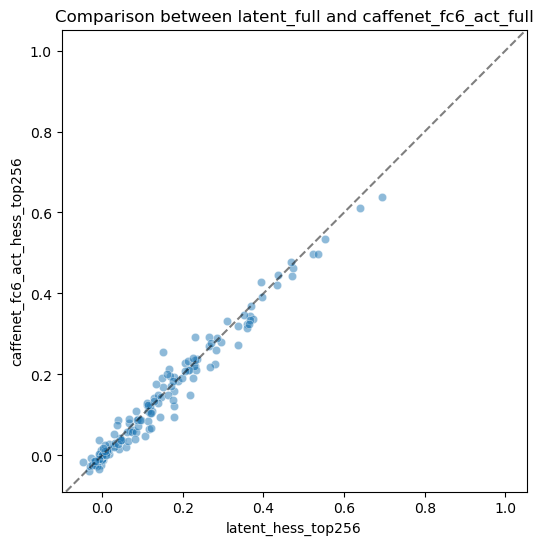

In [36]:
df_compare = stats_all_df.query("thread == 'thread0'").pivot(index="Expi",
                               columns="regressor_name",
                               values="test_score")
df_compare 
# plot the comparison between latent_full and caffenet_fc6_act_hess_top256
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_compare, x='latent_hess_top256', y='caffenet_fc6_act_hess_top256', alpha=0.5)
plt.title('Comparison between latent_full and caffenet_fc6_act_full')
# Add diagonal line
plt.axline((0, 0), (1, 1), linestyle='--', color='k', alpha=0.5)
plt.axis('equal')
plt.show()

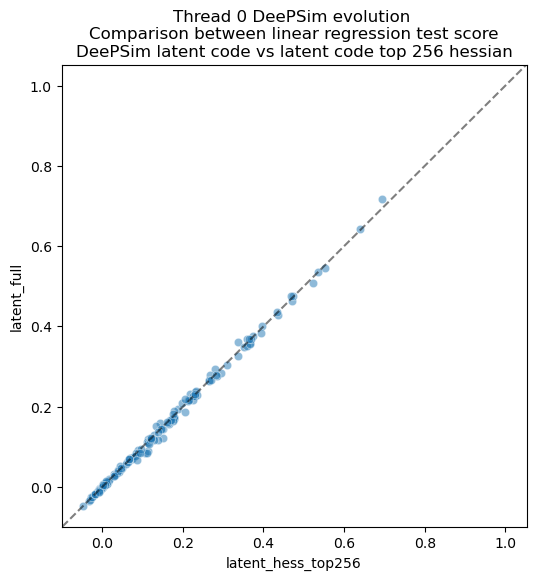

In [83]:
df_compare = stats_all_df.query("thread == 'thread0'").pivot(index="Expi",
                               columns="regressor_name",
                               values="test_score")
# plot the comparison between latent_full and caffenet_fc6_act_hess_top256
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_compare, x='latent_hess_top256', y='latent_full', alpha=0.5)
plt.title('Thread 0 DeePSim evolution \nComparison between linear regression test score\nDeePSim latent code vs latent code top 256 hessian')
# Add diagonal line
plt.axline((0, 0), (1, 1), linestyle='--', color='k', alpha=0.5) 
plt.axis('equal')
plt.show()


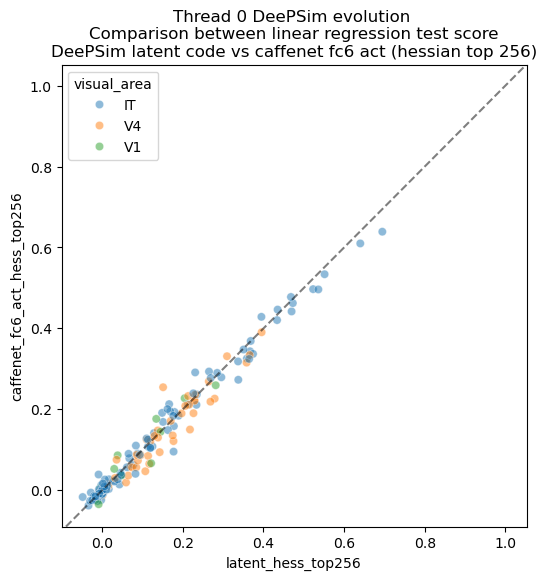

In [61]:
df_compare = stats_all_df.query("thread == 'thread0'").pivot(index="Expi",
                               columns="regressor_name",
                               values="test_score")
df_compare = df_compare.merge(meta_df, left_index=True, right_on='Expi', how='left').set_index('Expi')
df_compare 
# plot the comparison between latent_full and caffenet_fc6_act_hess_top256
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_compare, x='latent_hess_top256', y='caffenet_fc6_act_hess_top256', alpha=0.5, hue='visual_area')
plt.title('Thread 0 DeePSim evolution \nComparison between linear regression test score\nDeePSim latent code vs caffenet fc6 act (hessian top 256)')
# Add diagonal line
plt.axline((0, 0), (1, 1), linestyle='--', color='k', alpha=0.5)
plt.axis('equal')
plt.show()

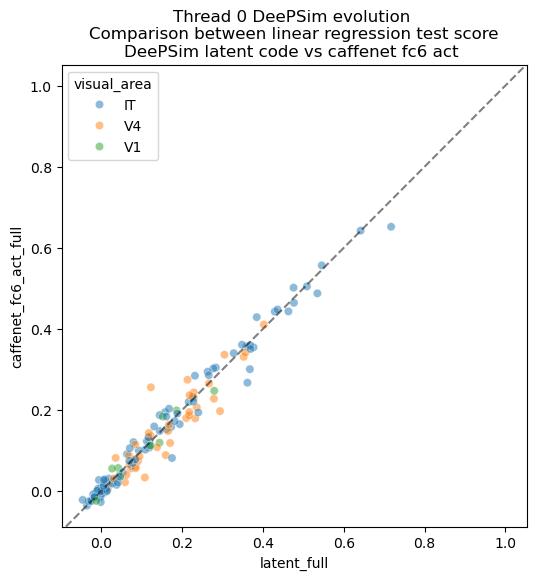

In [60]:
df_compare = stats_all_df.query("thread == 'thread0'").pivot(index="Expi",
                               columns="regressor_name",
                               values="test_score")
df_compare = df_compare.merge(meta_df, left_index=True, right_on='Expi', how='left').set_index('Expi')
df_compare 
# plot the comparison between latent_full and caffenet_fc6_act_hess_top256
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_compare, x='latent_full', y='caffenet_fc6_act_full', alpha=0.5, hue='visual_area')
plt.title('Thread 0 DeePSim evolution \nComparison between linear regression test score\nDeePSim latent code vs caffenet fc6 act ')
# Add diagonal line
plt.axline((0, 0), (1, 1), linestyle='--', color='k', alpha=0.5)
plt.axis('equal')

plt.show()

### BigGAN Evolution thread


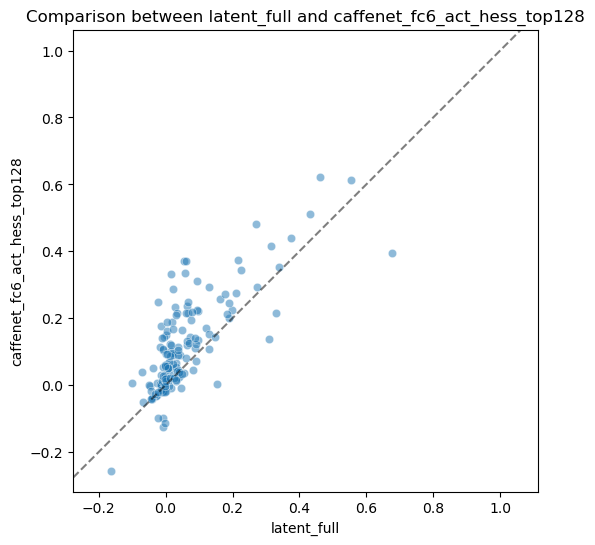

In [64]:
df_compare = stats_all_df.query("thread == 'thread1'").pivot(index="Expi",
                               columns="regressor_name",
                               values="test_score")
df_compare 
# plot the comparison between latent_full and caffenet_fc6_act_hess_top256
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_compare, x='latent_full', y='caffenet_fc6_act_hess_top128', alpha=0.5)
plt.title('Comparison between latent_full and caffenet_fc6_act_hess_top128')
# Add diagonal line
plt.axline((0, 0), (1, 1), linestyle='--', color='k', alpha=0.5)
plt.axis('equal')
plt.show()

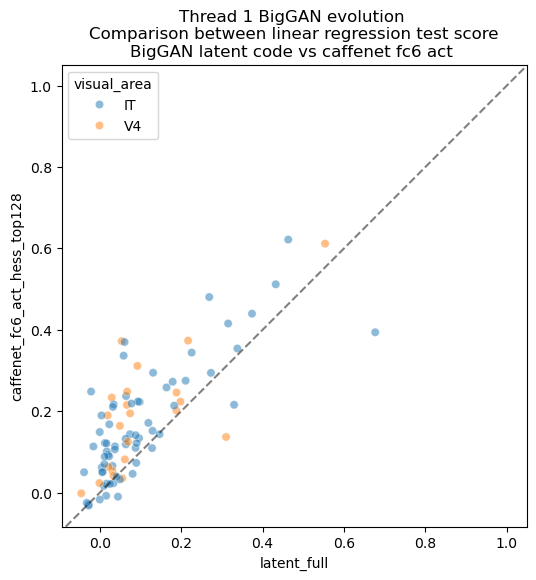

In [65]:
df_compare = stats_all_df.query("thread == 'thread1'").pivot(index="Expi",
                               columns="regressor_name",
                               values="test_score")
df_compare = df_compare.merge(meta_df, left_index=True, right_on='Expi', how='left').set_index('Expi')
df_compare 
# plot the comparison between latent_full and caffenet_fc6_act_hess_top256
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_compare.query("p_maxinit_1 < 0.01"), x='latent_full', y='caffenet_fc6_act_hess_top128', alpha=0.5, hue='visual_area')
plt.title('Thread 1 BigGAN evolution \nComparison between linear regression test score\nBigGAN latent code vs caffenet fc6 act ')
# Add diagonal line
plt.axline((0, 0), (1, 1), linestyle='--', color='k', alpha=0.5)
plt.axis('equal')
plt.show()

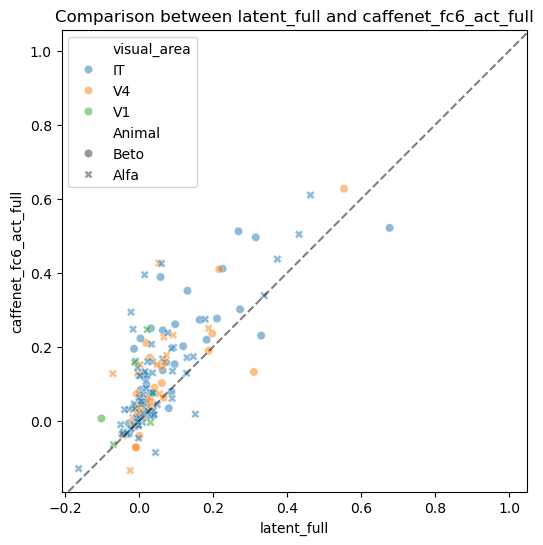

In [68]:
df_compare = stats_all_df.query("thread == 'thread1'").pivot(index="Expi",
                               columns="regressor_name",
                               values="test_score")
df_compare = df_compare.merge(meta_df, left_index=True, right_on='Expi', how='left').set_index('Expi')
df_compare 
# plot the comparison between latent_full and caffenet_fc6_act_hess_top256
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_compare, x='latent_full', y='caffenet_fc6_act_full', alpha=0.5, hue='visual_area', style="Animal")
plt.title('Comparison between latent_full and caffenet_fc6_act_full')
# Add diagonal line

plt.axline((0, 0), (1, 1), linestyle='--', color='k', alpha=0.5)
plt.axis('equal')
plt.show()

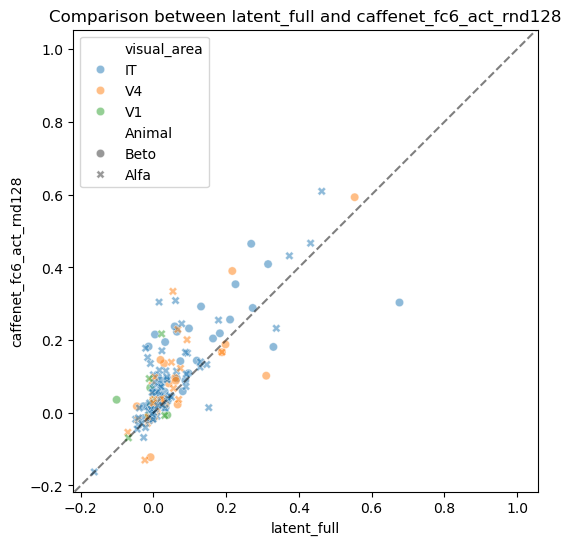

In [67]:
df_compare = stats_all_df.query("thread == 'thread1'").pivot(index="Expi",
                               columns="regressor_name",
                               values="test_score")
df_compare = df_compare.merge(meta_df, left_index=True, right_on='Expi', how='left').set_index('Expi')
df_compare 
# plot the comparison between latent_full and caffenet_fc6_act_hess_top256
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_compare, x='latent_full', y='caffenet_fc6_act_rnd128', alpha=0.5, hue='visual_area', style="Animal")
plt.title('Comparison between latent_full and caffenet_fc6_act_rnd128')
# Add diagonal line
plt.axline((0, 0), (1, 1), linestyle='--', color='k', alpha=0.5)
plt.axis('equal')
plt.show()

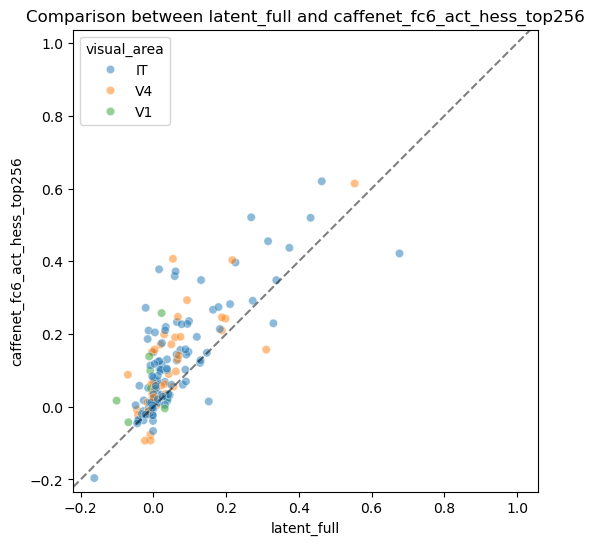

In [42]:
df_compare = stats_all_df.query("thread == 'thread1'").pivot(index="Expi",
                               columns="regressor_name",
                               values="test_score")
df_compare = df_compare.merge(meta_df[['Expi', 'visual_area']], left_index=True, right_on='Expi', how='left').set_index('Expi')
df_compare
# plot the comparison between latent_full and caffenet_fc6_act_hess_top256
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_compare, x='latent_full', y='caffenet_fc6_act_hess_top256', alpha=0.5, hue='visual_area')
plt.title('Comparison between latent_full and caffenet_fc6_act_hess_top256')
# Add diagonal line
plt.axline((0, 0), (1, 1), linestyle='--', color='k', alpha=0.5)
plt.axis('equal')
plt.show()

### Comparing threads

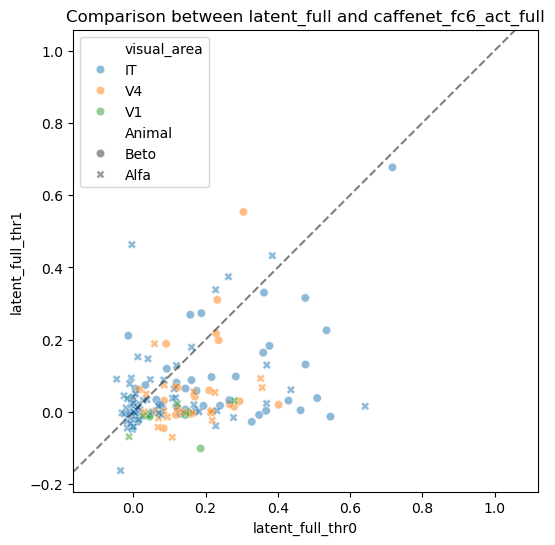

In [73]:
df_compare0 = stats_all_df.query("thread == 'thread0'").pivot(index="Expi",
                               columns="regressor_name",
                               values="test_score")

df_compare1 = stats_all_df.query("thread == 'thread1'").pivot(index="Expi",
                               columns="regressor_name",
                               values="test_score")
df_compare = df_compare0.merge(df_compare1, left_index=True, right_index=True, how='inner', suffixes=('_thr0', '_thr1'))
df_compare = df_compare.merge(meta_df, left_index=True, right_on='Expi', how='left').set_index('Expi')
# plot the comparison between latent_full and caffenet_fc6_act_hess_top256
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_compare, x='latent_full_thr0', y='latent_full_thr1', alpha=0.5, hue='visual_area', style="Animal")
plt.title('Comparison between latent_full and caffenet_fc6_act_full')
# Add diagonal line
plt.axline((0, 0), (1, 1), linestyle='--', color='k', alpha=0.5)
plt.axis('equal')
plt.show()

In [76]:
df_compare0.columns


Index(['caffenet_fc6_act_full', 'caffenet_fc6_act_hess_null128',
       'caffenet_fc6_act_hess_null256', 'caffenet_fc6_act_hess_top128',
       'caffenet_fc6_act_hess_top256', 'caffenet_fc6_act_rnd128',
       'caffenet_fc6_act_rnd256', 'latent_full', 'latent_hess_null128',
       'latent_hess_null256', 'latent_hess_top128', 'latent_hess_top256',
       'latent_rnd128', 'latent_rnd256'],
      dtype='object', name='regressor_name')

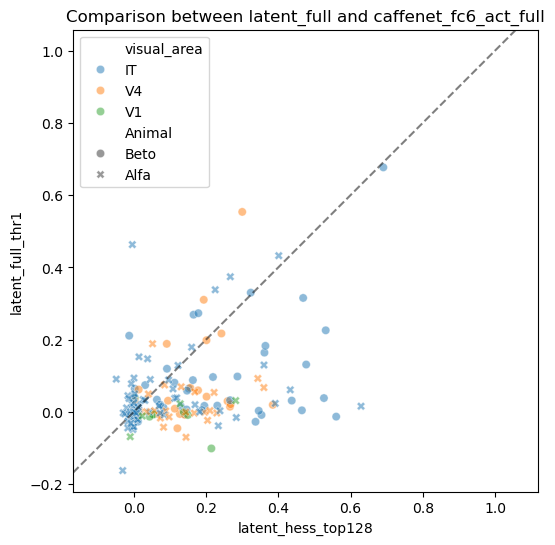

In [77]:
df_compare0 = stats_all_df.query("thread == 'thread0'").pivot(index="Expi",
                               columns="regressor_name",
                               values="test_score")

df_compare1 = stats_all_df.query("thread == 'thread1'").pivot(index="Expi",
                               columns="regressor_name",
                               values="test_score")
df_compare = df_compare0.merge(df_compare1, left_index=True, right_index=True, how='inner', suffixes=('_thr0', '_thr1'))
df_compare = df_compare.merge(meta_df, left_index=True, right_on='Expi', how='left').set_index('Expi')
# plot the comparison between latent_full and caffenet_fc6_act_hess_top256
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_compare, x='latent_hess_top128', y='latent_full_thr1', alpha=0.5, hue='visual_area', style="Animal")
plt.title('Comparison between latent_full and caffenet_fc6_act_full')
# Add diagonal line
plt.axline((0, 0), (1, 1), linestyle='--', color='k', alpha=0.5)
plt.axis('equal')
plt.show()

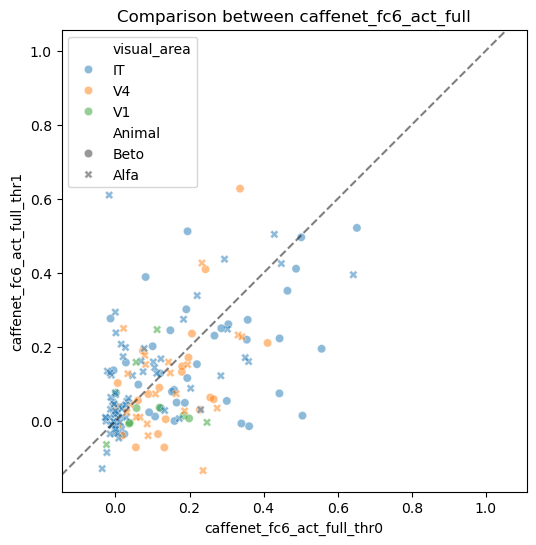

In [74]:
df_compare0 = stats_all_df.query("thread == 'thread0'").pivot(index="Expi",
                               columns="regressor_name",
                               values="test_score")

df_compare1 = stats_all_df.query("thread == 'thread1'").pivot(index="Expi",
                               columns="regressor_name",
                               values="test_score")
df_compare = df_compare0.merge(df_compare1, left_index=True, right_index=True, how='inner', suffixes=('_thr0', '_thr1'))
df_compare = df_compare.merge(meta_df, left_index=True, right_on='Expi', how='left').set_index('Expi')
# plot the comparison between latent_full and caffenet_fc6_act_hess_top256
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_compare, x='caffenet_fc6_act_full_thr0', y='caffenet_fc6_act_full_thr1', alpha=0.5, hue='visual_area', style="Animal")
plt.title('Comparison between caffenet_fc6_act_full')
# Add diagonal line
plt.axline((0, 0), (1, 1), linestyle='--', color='k', alpha=0.5)
plt.axis('equal')
plt.show()

In [19]:
stats_all = []
for Expi in range(1, len(BFEStats) + 1):
    if BFEStats[Expi - 1]["evol"] is None:
        continue

    print(f"Processing experiment {Expi}...")
    expdir = join(saveroot, f"Both_Exp{Expi:03d}")
    regression_path = join(expdir, f"latent_code_linear_neural_pred_results_Expi{Expi}.pkl")
    if not os.path.exists(regression_path):
        print(f"Regression results for experiment {Expi} not found. Skipping...")
        continue
    results = pkl.load(open(regression_path, "rb"))
    stats_row = {}
    for thread in ['thread0', 'thread1']:
        for regressor_name in results[thread]:
            # Split regressor name into model type and projection
            model_type, *proj_parts = regressor_name.split('_')
            projection = '_'.join(proj_parts) if proj_parts else 'full'
            
            # Create hierarchical column names
            base_key = (thread, Xtype, projection)
            stats_row[base_key + ('train_score',)] = results[thread][regressor_name]['train_score']
            stats_row[base_key + ('test_score',)] = results[thread][regressor_name]['test_score'] 
            stats_row[base_key + ('X_dim',)] = results[thread][regressor_name]['X_dim']
            stats_row[base_key + ('sample_num',)] = results[thread][regressor_name]['sample_num']
            stats_row[base_key + ('alpha',)] = results[thread][regressor_name]['alpha']
    stats_all.append(stats_row)

# Create DataFrame with MultiIndex columns
stats_all_df = pd.DataFrame(stats_all)
stats_all_df.columns = pd.MultiIndex.from_tuples(stats_all_df.columns, 
                                                names=['thread', 'model', 'projection', 'metric'])


Processing experiment 3...
Processing experiment 4...
Regression results for experiment 4 not found. Skipping...
Processing experiment 5...
Processing experiment 6...
Processing experiment 7...
Processing experiment 8...
Regression results for experiment 8 not found. Skipping...
Processing experiment 9...
Processing experiment 10...
Processing experiment 12...
Processing experiment 13...
Regression results for experiment 13 not found. Skipping...
Processing experiment 14...
Processing experiment 15...
Processing experiment 16...
Processing experiment 17...
Processing experiment 18...
Processing experiment 19...
Processing experiment 20...
Processing experiment 21...
Processing experiment 22...
Processing experiment 23...
Processing experiment 24...
Processing experiment 25...
Processing experiment 26...
Processing experiment 27...
Processing experiment 28...
Processing experiment 29...
Processing experiment 30...
Processing experiment 31...
Processing experiment 32...
Processing experi

In [20]:
stats_all_df

thread         thread0                                                        \
model           latent                                                         
projection        full                                           hess_top128   
metric     train_score test_score X_dim sample_num         alpha train_score   
0             0.348681   0.359201  4096       1842  1.232847e+06    0.343540   
1             0.442329   0.429260  4096       1283  8.697490e+05    0.436784   
2             0.083310   0.079456  4096       1483  2.477076e+06    0.081104   
3             0.468788   0.508713  4096       1160  6.135907e+05    0.464177   
4             0.014074   0.011155  4096       1000  4.977024e+06    0.010014   
..                 ...        ...   ...        ...           ...         ...   
162           0.082156   0.046490  4096       1240  1.747528e+06    0.068548   
163           0.263030   0.279335  4096        840  6.135907e+05    0.254758   
164           0.217792   0.121761  4096        872  8.697490e+05    0.221504   
165           0.050807  -0.012251  4096        872  1.747528e+06    0.051114   
166           0.111929   0.026556  4096        750  8.697490e+05    0.104206   

thread                                                 ...        thread1  \
model                                                  ...       caffenet   
projection                                             ... fc6_act_rnd256   
metric     test_score X_dim sample_num          alpha  ...    train_score   
0            0.361444   128       1842   37649.358068  ...       0.392063   
1            0.437047   128       1283   26560.877829  ...       0.167793   
2            0.081684   128       1483   75646.332755  ...       0.303287   
3            0.526160   128       1160   18738.174229  ...       0.221021   
4            0.011804   128       1000  215443.469003  ...       0.117687   
..                ...   ...        ...            ...  ...            ...   
162          0.045484   128       1240   75646.332755  ...       0.141693   
163          0.281913   128        840   18738.174229  ...       0.295189   
164          0.128276   128        872   26560.877829  ...       0.434196   
165         -0.010114   128        872   53366.992312  ...       0.120010   
166          0.023220   128        750   26560.877829  ...       0.188607   

thread                                                               \
model                                                                 
projection                                           fc6_act_rnd128   
metric     test_score X_dim sample_num         alpha    train_score   
0            0.252128   256       1152  18738.174229   3.346081e-01   
1            0.036406   256        802  26560.877829   1.220020e-01   
2            0.103032   256        927  18738.174229   2.845948e-01   
3           -0.001885   256        725  18738.174229   9.405323e-02   
4            0.028774   256        625  37649.358068   6.271336e-02   
..                ...   ...        ...           ...            ...   
162          0.060466   256        775  37649.358068   1.307268e-01   
163         -0.009144   256        539  13219.411485   1.662126e-01   
164          0.164468   256        561   4641.588834   3.000250e-01   
165         -0.050732   256        561  37649.358068   2.956659e-09   
166          0.135711   256        480  26560.877829   1.455472e-01   

thread                                                
model                                                 
projection                                            
metric     test_score X_dim sample_num         alpha  
0            0.204340   128       1152  1.321941e+04  
1            0.057864   128        802  2.656088e+04  
2            0.100318   128        927  9.326033e+03  
3            0.041587   128        725  2.656088e+04  
4            0.048561   128        625  3.764936e+04  
..                ...   ...        ...           ...  
162          0.072305   128

In [15]:
stats_all_df.columns[0]

('thread0_latent_full', 'train_score')

In [7]:
stats_row = {}
for thread in ['thread0', 'thread1']:
    for regressor_name in results[thread]:
        stats_row[thread + "_" + regressor_name + "train_score"] = results[thread][regressor_name]['train_score']
        stats_row[thread + "_" + regressor_name + "test_score"] = results[thread][regressor_name]['test_score']
        stats_row[thread + "_" + regressor_name + "X_dim"] = results[thread][regressor_name]['X_dim']
        stats_row[thread + "_" + regressor_name + "sample_num"] = results[thread][regressor_name]['sample_num']
        stats_row[thread + "_" + regressor_name + "alpha"] = results[thread][regressor_name]['alpha']

In [6]:
results

{'thread0': {'latent_full': {'model': RidgeCV(alphas=array([1.00000000e-03, 1.41747416e-03, 2.00923300e-03, 2.84803587e-03,
          4.03701726e-03, 5.72236766e-03, 8.11130831e-03, 1.14975700e-02,
          1.62975083e-02, 2.31012970e-02, 3.27454916e-02, 4.64158883e-02,
          6.57933225e-02, 9.32603347e-02, 1.32194115e-01, 1.87381742e-01,
          2.65608778e-01, 3.76493581e-01, 5.33669923e-01, 7.56463328e-01,
          1.07226722e+00, 1.51991108e+0...
          3.27454916e+08, 4.64158883e+08, 6.57933225e+08, 9.32603347e+08,
          1.32194115e+09, 1.87381742e+09, 2.65608778e+09, 3.76493581e+09,
          5.33669923e+09, 7.56463328e+09, 1.07226722e+10, 1.51991108e+10,
          2.15443469e+10, 3.05385551e+10, 4.32876128e+10, 6.13590727e+10,
          8.69749003e+10, 1.23284674e+11, 1.74752840e+11, 2.47707636e+11,
          3.51119173e+11, 4.97702356e+11, 7.05480231e+11, 1.00000000e+12])),
   'train_score': 0.11192864619813447,
   'test_score': 0.026555839841520323,
   'X_key': 